In [2]:
# Numerical
from jax.numpy import exp, newaxis, mean   # Arithematic
from jax.numpy import array, zeros, arange, where, ones # Array creation routines
from jax.numpy import float64
from jax.numpy import sum as vsum
from jax.numpy.linalg import solve, eigvals, norm
from jax.random import PRNGKey, uniform
from jax.lax import scan 
from jax import jit, jacrev, jacfwd, vmap, grad, jvp, vjp

# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

# Visualisation
import matplotlib.pyplot as plt

In [3]:
import jax.numpy as np
import jax.scipy as sc
import matplotlib.pyplot as plt

In [4]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [31]:
@jit
def analytic_solution(parameters, time_out, /, fluxes=cbm._fluxes, 
    contents=cbm._reservoir_content, decay=cbm._decay_matrix):
    """
    This is the analytic solution itself.
    Parameters: 
        
    Returns:
    """
    start_date = parameters[0]
    event_area = parameters[1]

    trop_prod = parameters[2]   
    strat_prod = 1 - trop_prod  # Less degrees of freedom 
    production = zeros((11,))
    production = production.at[:2].set([strat_prod, trop_prod])

    weights = ones(11, dtype=float64)
    weights = weights.at[0].set(parameters[3])  # Less degrees of freedom 
    weights = weights.at[2:].set(parameters[4:])

    # Constructs the transfer matrix 
    c_14_fluxes = fluxes / np.transpose(weights * contents)
    new_c_14_fluxes = np.diag(np.sum(c_14_fluxes, axis=1))
    transfer_matrix = np.transpose(c_14_fluxes) - new_c_14_fluxes - decay
    initial_position = event_area * production

    @jit
    @vmap
    def vmap_util(t, /, transfer_matrix=transfer_matrix, y0=initial_position, start=start_date):
        # Try vmap expm directly
        return sc.linalg.expm((t - start) * transfer_matrix) @ y0

    impulse_solution = vmap_util(time_out)
    steady_solution = np.zeros((impulse_solution.shape))
    condition = (time_out > start_date).reshape(-1, 1)
    
    return np.where(condition, impulse_solution, steady_solution)

In [32]:
parameters = array([774.86, 80.0, 0.3, *[1.0 for _ in range(10)]])
time_out = arange(770, 790)

In [33]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = array([row.strip().split(" ") for row in data], dtype=float64)
        return data.T


In [34]:
data = load("miyake12.csv")
data = data.at[1].add(-mean(data[1, 1:4]))

In [35]:
@jit
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    analytic_data = analytic_solution(parameters, data[0])
    return vsum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)

In [36]:
gradient = jit(grad(loss))
hessian = jit(jacfwd(jacrev(loss)))

In [39]:
%%timeit
loss(parameters)

640 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [42]:
%%timeit
gradient(parameters)

2.84 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%%timeit
hessian(parameters)

57.5 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [179]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=False)
mcmc.run(PRNGKey(11), init_params=parameters)

In [133]:
test = mcmc.get_samples()

In [145]:
import seaborn as sns
sns.set()

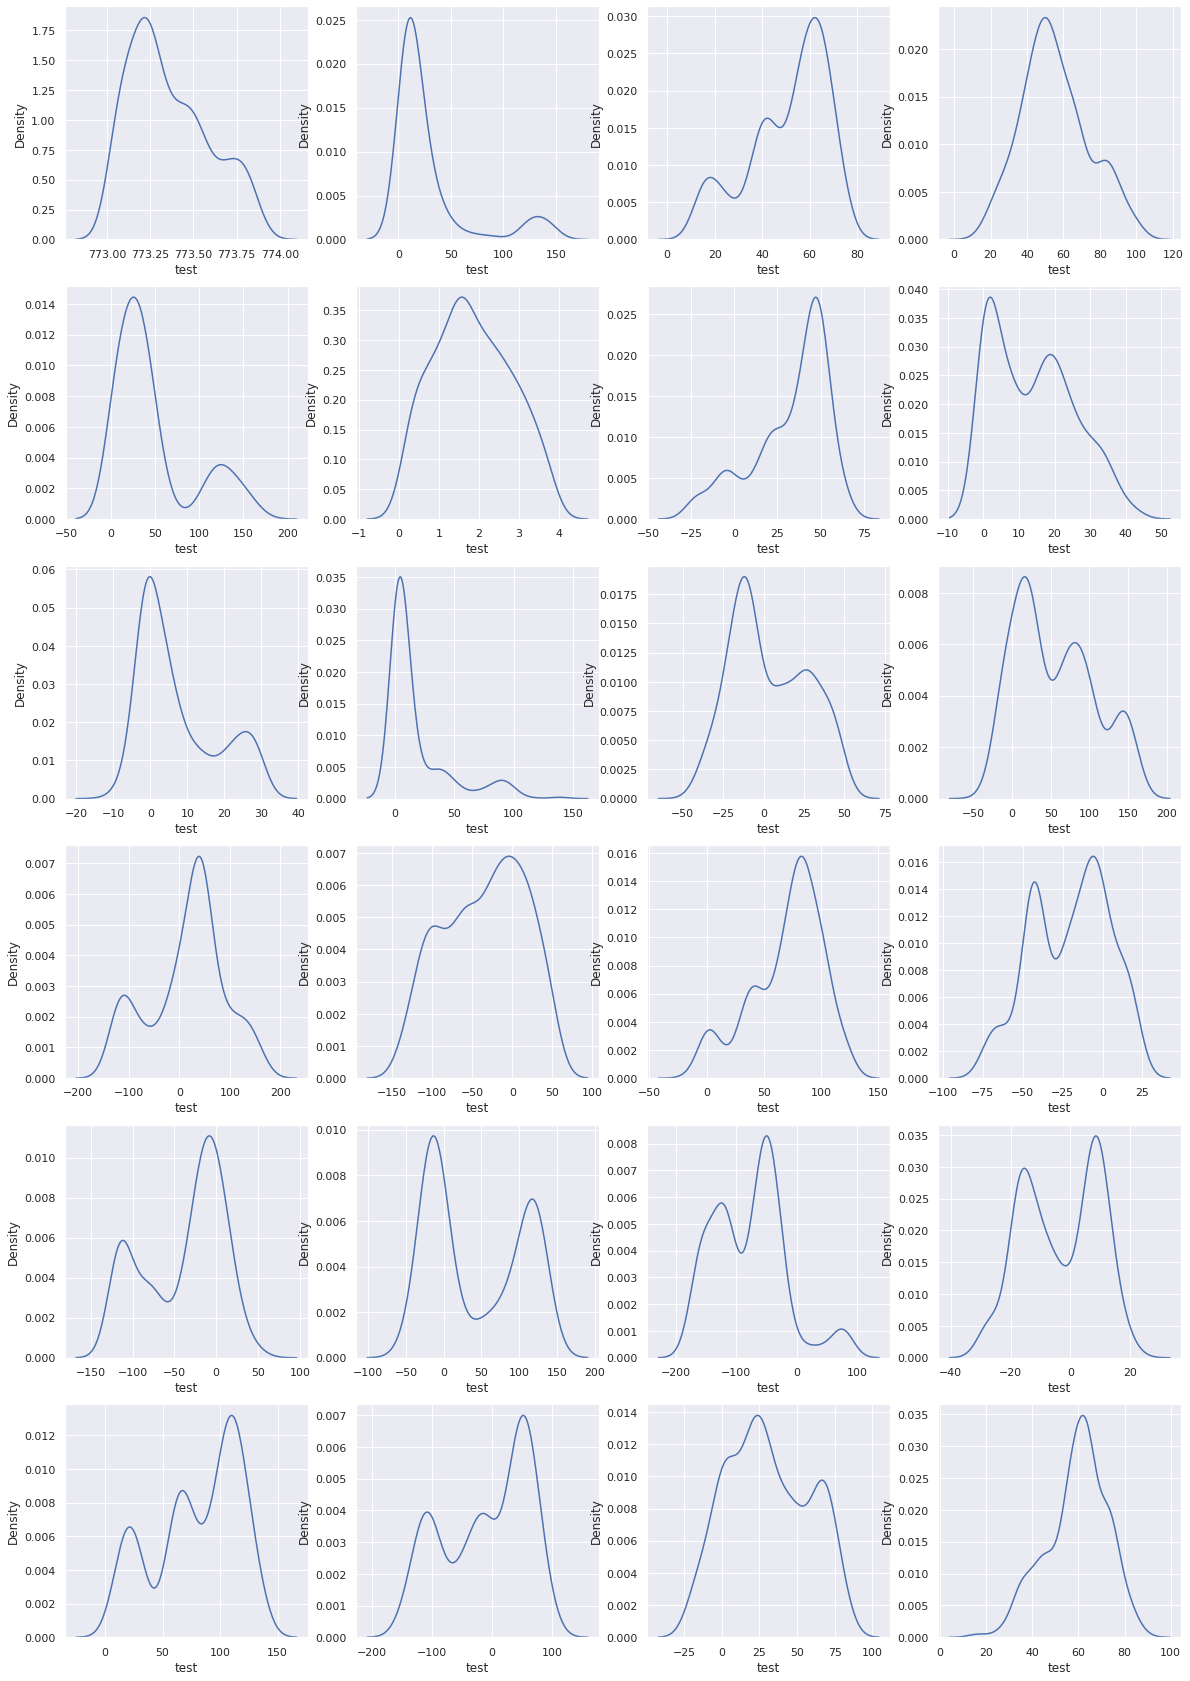

In [170]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30))
for index, variable in enumerate(test.T):
    axis = axes[index // 4][index % 4]
    sns.kdeplot(test.T[index], ax=axis)
    axis.set_xlabel("test")